# Predicting Player Login Patterns: Forecasting Hourly Login Counts on a Minecraft Research Server

# Introduction

For any online game server, it’s useful to know when players are most likely to log in. This helps with planning maintenance, managing server load, and understanding general player activity patterns. In many games, logins tend to follow clear time-of-day or day-of-week patterns, so it’s reasonable to ask whether we can predict player activity ahead of time.

In this project, we focus on the question:

**Can we predict how many unique players will log into the server during a given hour?**

To explore this, we use an anonymized play session log from a Minecraft research server hosted by the University of British Columbia. Each row in the dataset represents one gameplay session, including when a player logged in and when they logged out. The session log file (`sessions.csv`) contains 1,535 rows and the following variables:

- **hashedEmail** — anonymized player ID  
- **start_time** — session start timestamp (YYYY-MM-DD HH:MM:SS)  
- **end_time** — session end timestamp (YYYY-MM-DD HH:MM:SS)  
- **original_start_time** — raw start timestamp before adjustment  
- **original_end_time** — raw end timestamp before adjustment  

Using these timestamps, we transform the data into an hourly-level dataset. For each session start time, we extract several useful variables:

- **date** — calendar date of the login  
- **hour** — hour of day (0–23)  
- **weekday** — day of week (Mon–Sun)  
- **is_weekend** — TRUE/FALSE indicator for weekends  
- **n_logins** — number of unique players starting a session during each hour (our target variable)

This processed dataset is what we use for our exploratory analysis and for building a model to forecast hourly login counts.



## Methods

The Methods section includes three main steps:

1. Preparing the dataset and exploring basic login patterns  
2. Building two predictive models (a simple baseline and a kNN model)  
3. Comparing their performance using RMSE and MAE  

Below, each step is described alongside the corresponding code.


## 1. Loading libraries and importing the data

We start by loading the packages used for data manipulation, working with timestamps, visualization, and modelling. We then read the session log dataset (`sessions.csv`), where each row represents one gameplay session on the Minecraft research server.

In [46]:
# Load packages and set seed
set.seed(18)
library(tidyverse)
library(lubridate)
library(tidymodels)
options(repr.matrix.max.rows = 6)

# Read the session log dataset
sessions <- read_csv("data/sessions.csv")
sessions


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


## 2. Cleaning and preparing the timestamp variables

The session timestamps are stored as character strings, so we convert them into proper datetime objects. We also remove rows with missing timestamps to ensure that each session is associated with a valid start time.


In [47]:
# Convert timestamp strings to datetime and remove missing values
sessions_clean <- sessions |>
  mutate(
    start_time = dmy_hm(start_time),
    end_time   = dmy_hm(end_time)
  ) |>
  drop_na(start_time)


## 3. Creating hourly features and aggregating login counts

To study login patterns and build our prediction model, we transform the session-level data into an hourly dataset.  
For each session, we extract:

- calendar date  
- hour of the day  
- weekday label  
- weekend indicator  

We then compute the number of **unique players** who started a session in each hour. This becomes our target variable `n_logins`.


In [48]:
# Create hourly features and compute hourly unique login counts
login_counts <- sessions_clean |>
  mutate(
    date      = as_date(start_time),
    hour      = hour(start_time),
    weekday   = wday(start_time, label = TRUE, abbr = TRUE),
    is_weekend = weekday %in% c("Sat", "Sun")
  ) |>
  group_by(date, hour, weekday, is_weekend) |>
  summarise(
    n_logins = n_distinct(hashedEmail),
    .groups = "drop"
  )

login_counts


date,hour,weekday,is_weekend,n_logins
<date>,<int>,<ord>,<lgl>,<int>
2024-04-06,9,Sat,TRUE,1
2024-04-06,20,Sat,TRUE,1
2024-04-06,22,Sat,TRUE,1
⋮,⋮,⋮,⋮,⋮
2024-09-21,23,Sat,TRUE,1
2024-09-24,6,Tue,FALSE,1
2024-09-26,6,Thu,FALSE,1


## 4. Splitting the data into training and testing sets

Because the data represent a time series of hourly counts, we split the dataset chronologically:  
the first 75% of the hours form the training set, and the remaining 25% are used for testing.  
This allows us to evaluate how well the model predicts future login behavior.


In [49]:
# Order data by time before splitting
login_counts <- login_counts |> arrange(date, hour)

# Time-based split
data_split <- initial_time_split(login_counts, prop = 0.75)
train_data <- training(data_split)
test_data  <- testing(data_split)

train_data |> head()


date,hour,weekday,is_weekend,n_logins
<date>,<int>,<ord>,<lgl>,<int>
2024-04-06,9,Sat,TRUE,1
2024-04-06,20,Sat,TRUE,1
2024-04-06,22,Sat,TRUE,1
2024-04-07,0,Sun,TRUE,1
2024-04-07,2,Sun,TRUE,1
2024-04-07,5,Sun,TRUE,2


## 5. Exploratory visualization

To get a sense of when players tend to log in, we plot the average number of logins for each hour of the day. This helps us see basic daily patterns before fitting any models.


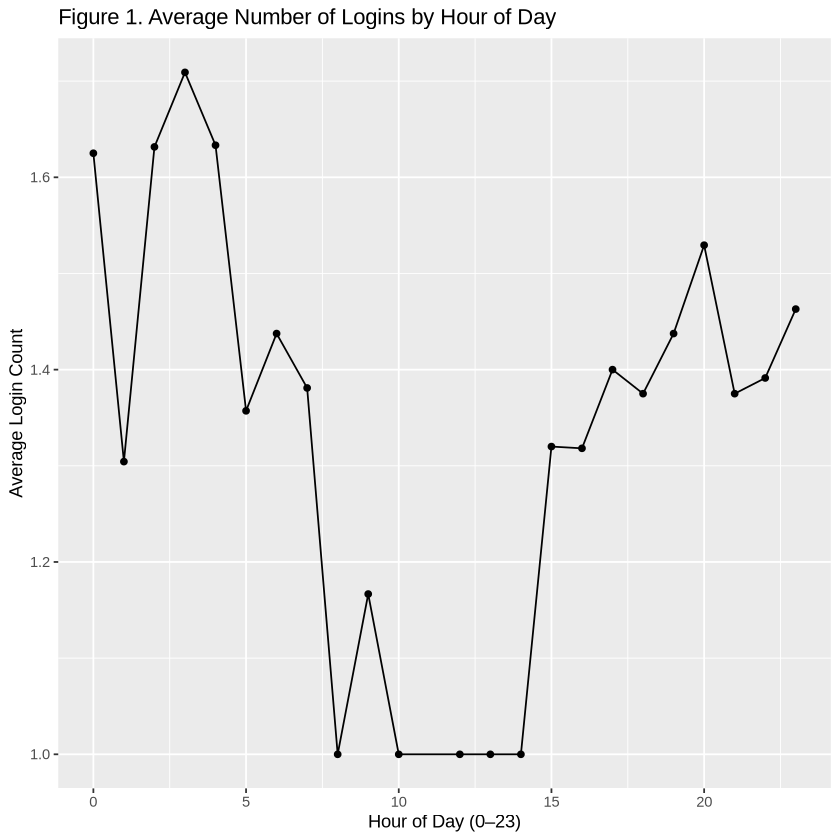

In [50]:
# Use training data for EDA
eda_plot <- train_data |>
  group_by(hour) |>
  summarise(mean_logins = mean(n_logins), .groups = "drop") |>
  ggplot(aes(x = hour, y = mean_logins)) +
  geom_line() +
  geom_point() +
  labs(
    title = "Figure 1. Average Number of Logins by Hour of Day",
    x = "Hour of Day (0–23)",
    y = "Average Login Count"
  )

eda_plot


## 6. Baseline model

As a simple benchmark, we use a baseline model that predicts the mean login count for each hour based on the training data. This gives us a reference level of error to compare our predictive model against.


In [51]:
baseline_by_hour <- train_data |>
  group_by(hour) |>
  summarise(baseline_pred = mean(n_logins), .groups = "drop")

test_with_baseline <- test_data |>
  left_join(baseline_by_hour, by = "hour")

error_metrics <- metric_set(rmse, mae)

baseline_metrics <- error_metrics(
  data = test_with_baseline,
  truth = n_logins,
  estimate = baseline_pred
)

baseline_metrics


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.7790357
mae,standard,0.6002234


## 7. Building the Prediction Model

To go beyond simple hourly averages, we fit a k-nearest neighbours (kNN) regression model to predict hourly login counts. The model uses only three time-based features—hour of day, weekday, and a weekend indicator. These reflect the main temporal patterns in the dataset. We train the model on the first 75% of the observations and evaluate it on the remaining 25%.


In [52]:
# Build recipe
login_recipe <- recipe(n_logins ~ hour + weekday + is_weekend, data = train_data) |>
  step_dummy(all_nominal_predictors())

# Correct kNN model specification (use neighbors instead of k)
knn_spec <- nearest_neighbor(
  mode = "regression",
  neighbors = 5
) |>
  set_engine("kknn")

# Workflow
knn_workflow <- workflow() |>
  add_recipe(login_recipe) |>
  add_model(knn_spec)

# Fit the model
knn_fit <- knn_workflow |>
  fit(data = train_data)

# Predict on test set
knn_predictions <- predict(knn_fit, test_data) |>
  bind_cols(test_data)

# Compute metrics
knn_metrics <- metric_set(rmse, mae)(
  data = knn_predictions,
  truth = n_logins,
  estimate = .pred
)

knn_metrics


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.8515930
mae,standard,0.5962226


## 8. Model Evaluation

To see whether the kNN model actually improves prediction accuracy, we compare it with the simple baseline that predicts the mean login count for each hour. We combine the RMSE and MAE values from both models into a single table and visualize the difference. Lower values represent better performance.


In [53]:
combined_metrics <- bind_rows(
  mutate(knn_metrics, model = "kNN"),
  mutate(baseline_metrics, model = "Baseline")
)

combined_metrics


.metric,.estimator,.estimate,model
<chr>,<chr>,<dbl>,<chr>
rmse,standard,0.8515930,kNN
mae,standard,0.5962226,kNN
rmse,standard,0.7790357,Baseline
mae,standard,0.6002234,Baseline


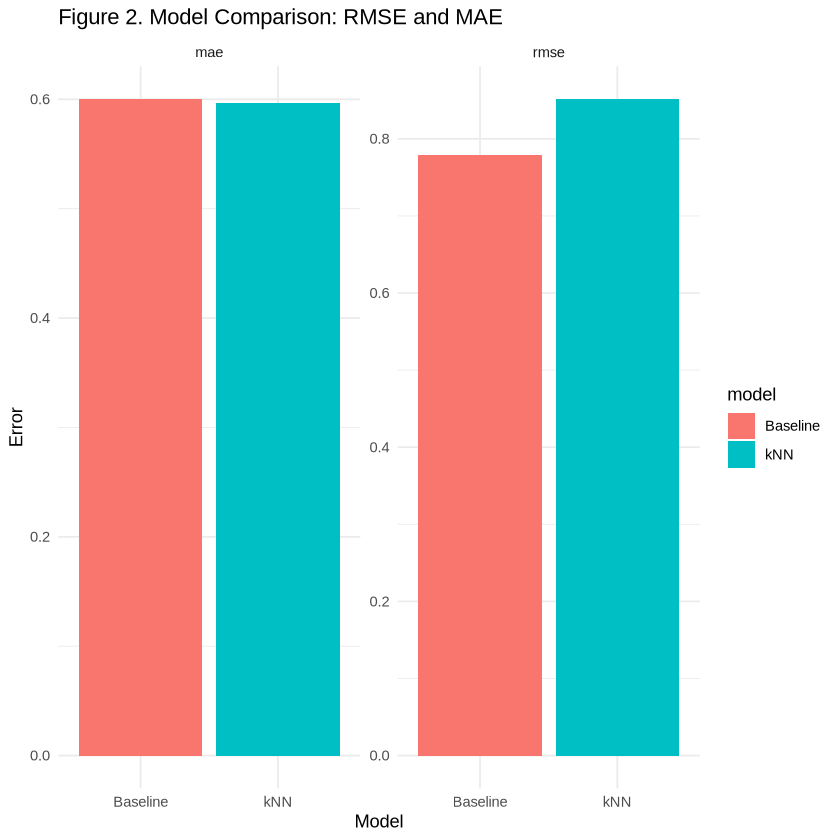

In [54]:
ggplot(combined_metrics, aes(x = model, y = .estimate, fill = model)) +
  geom_col() +
  facet_wrap(~ .metric, scales = "free_y") +
  labs(
    title = "Figure 2. Model Comparison: RMSE and MAE",
    x = "Model",
    y = "Error"
  ) +
  theme_minimal()


### Summary of Model Evaluation

Overall, the kNN regression model does not outperform the simple baseline model.The baseline method achieves a lower RMSE, and the MAE values for the two models are very similar. This suggests that simple hourly averages already capture most of the login patterns in this dataset. The features we used (hour of day, weekday, weekend indicator) do not provide enough extra information  
for kNN to make better predictions.